### Import packages

In [141]:
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from scipy import signal, interpolate, stats
sys.path.append("/home/michael/Synology/Desktop/Data/Python/Gait-Signatures/NeuralODE/DDFA_NODE/")
from src.tde import embed_data, takens_embedding
from src.utils_data_preparation import change_trial_length, split_data
from src.delase import get_aics, get_λs
from src import phaser
from src import stats as statistics

from tqdm.auto import tqdm
import torch

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import warnings
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [2]:
# data = torch.from_numpy(np.load("/home/michael/Synology/Julia/data/human_data.npy"))
# data -= data.mean(axis=1)[:, np.newaxis, :]
n_delays = 1
matrix_size = 10
delay_interval = 1
rank = None
rank_thresh = None
rank_explained_variance = None
lamb=0
dt = 0.002
N_time_bins = 50
max_freq=(1/dt)//2
max_unstable_freq=(1/dt)//2
device = torch.device("cuda")
verbose = True
# data = data.to(device)

In [4]:
all_data = torch.from_numpy(np.load("/home/michael/Synology/Desktop/Data/Julia/data/VDP_SDEs.npy")[:, 5000:15000, :].astype(np.float32))
# all_data = torch.from_numpy(np.load("../../Julia/data/human_data.npy").astype(np.float32))
dt = 1/100
all_data -= all_data.mean(axis=1)[:, None, :]
all_data = all_data.to(device)

### Simulate Data

In [148]:
from scipy.integrate import odeint
import sdeint
def vec_field(y, t):
    return A @ y
def weiner(y, t):
    return B

In [ ]:
from tqdm.notebook import tqdm
max_λs = np.arange(-1.0, 0, 0.1)
keep_dims = 10
timesteps = 20000
transient = 2000
dt = 0.002
n = 100
μ = 0
σ = 1/np.sqrt(n)
B = np.diag(np.ones(n))/10
reps = 20

def update_matrix(A, λ_new):
        n = A.shape[0]
        λ_max = np.sort(np.linalg.eigvals(A).real)[-1]
        A_new = A - λ_max*np.eye(n) + λ_new*np.eye(n)
        return A_new

data = np.zeros((len(max_λs), reps, timesteps - transient, keep_dims))
for idx, max_λ in enumerate(max_λs):
    for jdx in tqdm(range(reps)):
        A = np.random.normal(μ, σ, size=(n, n))
        A = update_matrix(A, max_λ)

        ts = np.linspace(0, int(timesteps*dt), timesteps)
        y0 = np.random.randn(n)


        inds = np.random.permutation(n)[:keep_dims]            
        sol = sdeint.itoint(vec_field, weiner, y0, ts)[transient:, inds]
        data[idx, jdx, :, :] = sol

In [ ]:
import copy
all_data = torch.from_numpy(copy.deepcopy(data)).float().to(device)
all_data.shape

### Helper functions

In [6]:
def embed_signal_torch(data, n_delays, delay_interval=1):
    """
    Create a delay embedding from the provided tensor data.
    """

    with torch.no_grad():
        if isinstance(data, np.ndarray):
            data = torch.from_numpy(data)
        device = data.device

        # initialize the embedding
        if data.ndim == 3:
            embedding = torch.zeros((data.shape[0], data.shape[1] - (n_delays - 1)*delay_interval, data.shape[2]*n_delays)).to(device)
        else:
            embedding = torch.zeros((data.shape[0] - (n_delays - 1)*delay_interval, data.shape[1]*n_delays)).to(device)
        
        for d in range(n_delays):
            index = (n_delays - 1 - d)*delay_interval
            ddelay = d*delay_interval

            if data.ndim == 3:
                ddata = d*data.shape[2]
                embedding[:,:, ddata: ddata + data.shape[2]] = data[:,index:data.shape[1] - ddelay]
            else:
                ddata = d*data.shape[1]
                embedding[:, ddata:ddata + data.shape[1]] = data[index:data.shape[0] - ddelay]
        
        return embedding

def product_safe(x):
    x_abs_sort_inds = np.abs(x).argsort()
    x = x[x_abs_sort_inds]
    prod = 1
    for i in range(int(len(x)/2)):
        prod *= x[i]
        prod *= x[x.shape[0] - i - 1]
    if len(x) % 2 != 0:
        prod *= x[int(len(x)/2)]
    
    # print(prod)

    return prod

def elle(i, yy, xx):
    xx_trimmed = xx[np.where(xx != xx[i])[0]]

    return product_safe(np.divide(yy - xx_trimmed, xx[i] - xx_trimmed))

def cheb(N, T):    
    if N == 0:
        return 0, 1

    xx = np.cos(np.pi*np.arange(N + 1)/N)
    xx = T*(xx - 1)/2
    c = np.multiply(np.hstack([2, np.ones(N - 1), 2]), np.power(-1, np.arange(N + 1)))
    X = matlib.repmat(xx, N + 1, 1).T
    dX = X - X.T
    D = np.divide(np.outer(c, 1/c), dX + np.eye(N + 1))
    D = D - np.diag(np.sum(D.T, axis=0))
    
    return D, xx

### Analysis

In [5]:
# matrix_sizes = np.array([10, 20, 50, 100, 200, 300, 500, 750, 1000])
# ranks = np.array([3, 5, 10, 25, 50, 75, 100, 125, 150, 200, *range(250, 801, 50), 900, 1000])
matrix_sizes = np.array([5, 10, 20])
ranks = np.array([3, 5, 10, 20])

aics = get_aics(all_data, matrix_sizes, ranks, dt=dt, max_freq=None,
                max_unstable_freq=None, device=torch.device("cuda"), delay_interval=1, N_time_bins=50)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [195]:
dataset_size = all_data.shape[1]
n_splits = 4

full_output = True
top_percent = 10
if full_output:
    top_percent = None

trial_lens = np.logspace(8, 8+n_splits-1, n_splits, base=2).astype(int)
skip = trial_lens // 2
all_λs = np.empty((len(trial_lens), all_data.shape[0]), dtype=object)
for idx, trial_len in enumerate(trial_lens):
    print(f"Trial Length: {trial_len}")
    λs = get_λs(all_data, aics, matrix_sizes, ranks, full_output=full_output,
           top_percent=top_percent, dt=dt, max_freq=None, max_unstable_freq=None,
           device=torch.device("cuda"), trial_len=trial_len, skip=skip[idx],  n_delays=None,
                                delay_interval=1, N_time_bins=50)
    for jdx in range(all_data.shape[0]):
        all_λs[idx, jdx] = λs[jdx]

Trial Length: 256
Trial Length: 512
Trial Length: 1024
Trial Length: 2048


In [124]:
def get_shape_mode(λs):
    return stats.mode([λ.shape for λ in λs])

def filter_λs(λs, shape):
    return [λ for λ in λs if λ.shape == shape]

(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 77.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 77.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 77.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 77.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5., 72.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6., 71.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 36., 41.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40., 37.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 60., 17.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 61., 16.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 74.,  3.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 75.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 10., 67.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 21., 56.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 48., 29.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  4., 63.,  9.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  4., 1

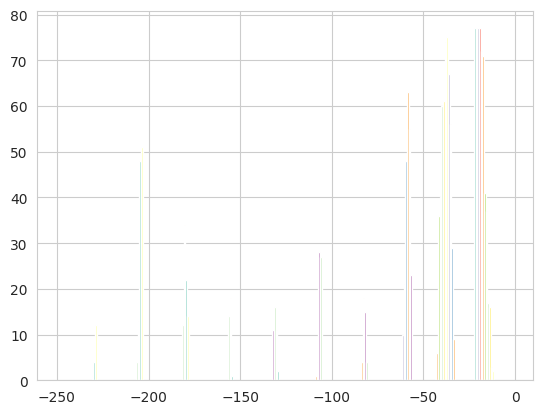

In [196]:
λs = np.zeros((all_λs.shape[0], all_λs.shape[1]), dtype=object)
for idx in range(all_λs.shape[0]):
    for jdx in range(all_λs.shape[1]):
        λs[idx, jdx] = np.stack(filter_λs(all_λs[idx, jdx], get_shape_mode(all_λs[idx, jdx]).mode))
plt.hist(λs[0, 0])

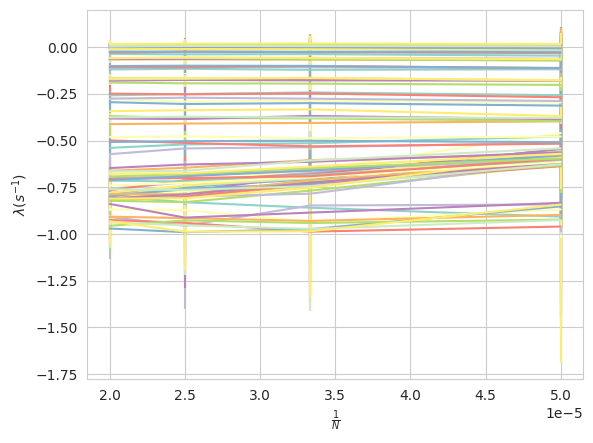

In [197]:
subject = 10
one_over_n_splits = (1 / np.arange(2, n_splits+2, 1)) / dataset_size

for subject in range(all_λs.shape[1]):
    dat = λs[:, subject]
    dat_means = np.array([λ.mean(axis=0) for λ in dat])
    dat_stds = np.array([λ.std(axis=0) for λ in dat])
    plt.errorbar(one_over_n_splits, dat_means[:, 0], yerr=dat_stds[:, 0])
    plt.xlabel(r"$\frac{1}{N}$")
    plt.ylabel(r"$\lambda (s^{-1})$")
plt.show()

In [215]:
def analyze_lambda_convergence(λs, one_over_n_splits, eig=0, max_splits=None, max_poly_degree=3):
    n_splits, n_subjects = λs.shape
    
    if max_splits is None:
        max_splits = n_splits
    
    results = {}
    
    for subject in range(n_subjects):
        subject_results = {}
        
        # Prepare data
        X = one_over_n_splits[-max_splits:].reshape(-1, 1)  # Use the last max_splits points
        y = np.array([λs[i, subject][:, eig].mean() for i in range(-max_splits, 0)])  # Use the last max_splits points
        weights = 1/np.array([λs[i, subject][:, eig].std() for i in range(-max_splits, 0)])  # Use the last max_splits points
        
        # Perform weighted linear regression
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            coeffs = np.polyfit(X.flatten(), y, 1, w=weights)
            slope, intercept = coeffs
        
        # Calculate R-squared
        y_pred = slope * X.flatten() + intercept
        ss_tot = np.sum(weights * (y - np.mean(y))**2)
        ss_res = np.sum(weights * (y - y_pred)**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Calculate standard error of intercept
        n = len(X)
        x_bar = np.mean(X)
        s_xx = np.sum(weights * (X.flatten() - x_bar)**2)
        s_e = np.sqrt(np.sum(weights * (y - y_pred)**2) / (n - 2))
        intercept_std_err = s_e * np.sqrt(1/n + x_bar**2/s_xx)
        
        subject_results['linear'] = {
            'intercept': intercept,
            'intercept_std_err': intercept_std_err,
            'slope': slope,
            'r_squared': r_squared,
        }
        
        poly_results = get_polynomial_regression(X, y, weights, max_poly_degree)
        
        # Find the best polynomial model based on BIC
        best_poly = min(poly_results, key=lambda x: x['bic'])
        subject_results['best_polynomial'] = best_poly
        
        results[f'subject_{subject}'] = subject_results
    
    return results

def get_polynomial_regression(X, y, weights, max_poly_degree=3):
    poly_results = []
    for degree in range(1, max_poly_degree + 1):
        poly_features = PolynomialFeatures(degree=degree)
        X_poly = poly_features.fit_transform(X)
        
        model = LinearRegression()
        model.fit(X_poly, y, sample_weight=weights)
        
        y_pred = model.predict(X_poly)
        mse = mean_squared_error(y, y_pred, sample_weight=weights)
        n_params = degree + 1
        n_samples = len(y)
        
        # Handle zero MSE case
        if mse == 0:
            bic = np.inf
        else:
            bic = n_samples * np.log(mse) + n_params * np.log(n_samples)
        
        poly_results.append({
            'degree': degree,
            'coefficients': model.coef_,
            'intercept': model.intercept_,
            'bic': bic
        })
    return poly_results

def plot_lambda_convergence(λs, one_over_n_splits, results, max_splits=None, eig=0, subject=0):
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    if max_splits is None:
        max_splits = λs.shape[0]
    
    # Plot data points with error bars
    y = np.array([λs[i, subject][:, eig].mean() for i in range(-max_splits, 0)])
    yerr = np.array([λs[i, subject][:, eig].std() for i in range(-max_splits, 0)])
    plt.scatter(x=one_over_n_splits[-max_splits:], y=y, s=50, c="k")
    plt.errorbar(one_over_n_splits[-max_splits:], y, yerr=yerr, fmt='none', capsize=5, alpha=0.75, c="k")
    
    # Plot linear regression
    linear_result = results[f'subject_{subject}']['linear']
    x_range = np.linspace(0, one_over_n_splits[-max_splits:].max(), 100)
    y_pred = linear_result['slope'] * x_range + linear_result['intercept']
    plt.plot(x_range, y_pred, color='r', label='Linear fit', lw=2)
    plt.errorbar(x=0.0, y=linear_result['intercept'], yerr=linear_result['intercept_std_err'], color='r', label='Intercept', lw=2)
    plt.scatter(x=0.0, y=linear_result['intercept'], c="r", s=50)

    plt.xlabel('1/N')
    plt.ylabel('λ')
    plt.title(f'Lambda Convergence for Subject {subject}')
    
    # Add text with regression results
    text = f"Linear fit:\ny-intercept = {linear_result['intercept']:.4f} ± {linear_result['intercept_std_err']:.4f}\n"
    text += f"R² = {linear_result['r_squared']:.4f}"
    plt.text(0.05, 0.95, text, transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.legend()
    plt.show()

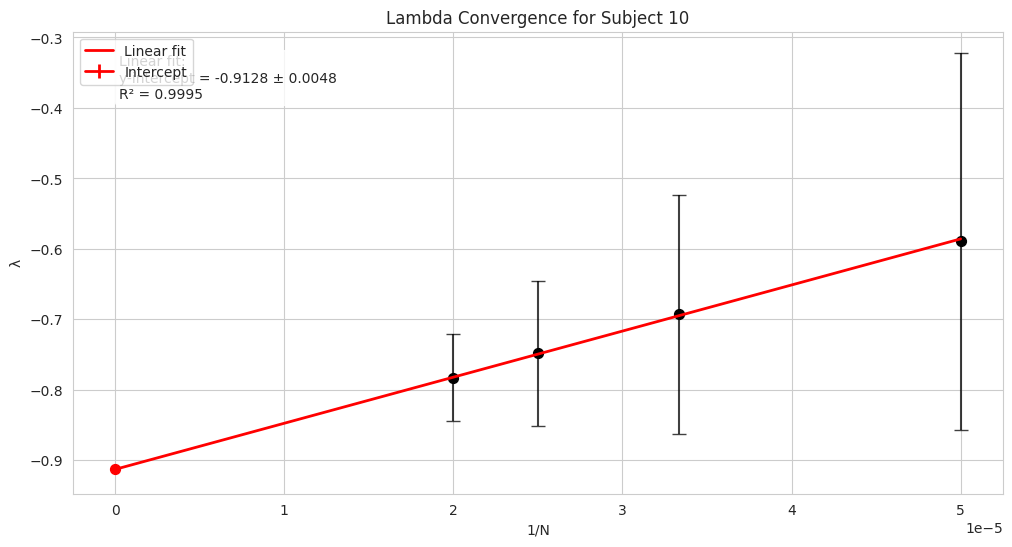

In [221]:
results = analyze_lambda_convergence(λs, one_over_n_splits, eig=0, max_splits=4, max_poly_degree=3)

# Plot for a specific subject (e.g., subject 0)
plot_lambda_convergence(λs, one_over_n_splits, results, eig=0, max_splits=4, subject=10)

In [218]:
def results_to_dataframe(results):
    data = []
    for subject, result in results.items():
        linear = result['linear']
        poly = result['best_polynomial']
        data.append({
            'Subject': subject,
            'Linear_Intercept': linear['intercept'],
            'Linear_Intercept_StdErr': linear['intercept_std_err'],
            'Linear_Slope': linear['slope'],
            'Linear_R_Squared': linear['r_squared'],
            'Best_Poly_Degree': poly['degree'],
            'Best_Poly_Intercept': poly['intercept'],
            'Best_Poly_BIC': poly['bic']
        })
    return pd.DataFrame(data)

# Convert results to DataFrame
results_df = results_to_dataframe(results)

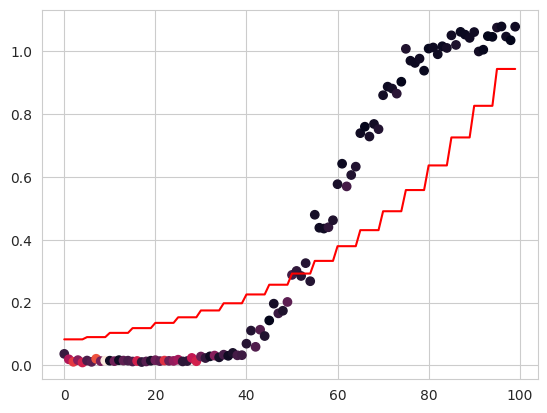

In [241]:
real_eigs = np.repeat(np.load("/home/michael/Synology/Desktop/Data/Julia/data/VDP_eigenvalues_ground_truth.npy"), 5, axis=0)
intercepts = results_df['Linear_Intercept']
std_errs = results_df['Linear_Intercept_StdErr']
plt.scatter(range(len(intercepts)), np.power(100, intercepts), c=std_errs)
plt.plot(range(len(real_eigs)), real_eigs[:, 0], c="r")

In [ ]:
real_eigs = np.repeat(np.load("../../Julia/data/VDP_eigenvalues_ground_truth.npy"), 5, axis=0)
plt.plot(np.exp(λs[:]))
plt.plot((real_eigs[:, 0]))

In [ ]:
plt.scatter(max_λs, λs[:, -1])
# plt.errorbar(max_λs, λs[:, -1], np.sqrt(λs[:, :, -1].std(axis=1)/20))
plt.plot(max_λs, max_λs, color="k", linestyle="--")

In [290]:
keep_eigs = 1
# λs_filtered = np.array([np.sort(λ)[-keep_eigs:] for λ in λs])
λs_filtered = np.stack([[np.sort(λ_i)[-keep_eigs:] for λ_i in λ] for λ in λs])

In [ ]:
[plt.scatter(max_λs, λs_filtered[:, :, idx].mean(axis=1)) for idx in range(keep_eigs)]
[plt.errorbar(max_λs, λs_filtered[:, :, idx].mean(axis=1), yerr=np.sqrt(λs_filtered[:, :, idx].var(axis=1)/reps)) for idx in range(keep_eigs)]
plt.plot(max_λs, max_λs, lw=2, c='k', linestyle="dashed")

In [ ]:
[plt.scatter(max_λs, λs_filtered[:, :, idx].mean(axis=1)) for idx in range(keep_eigs)]
[plt.errorbar(max_λs, λs_filtered[:, :, idx].mean(axis=1), yerr=np.sqrt(λs_filtered[:, :, idx].var(axis=1)/reps)) for idx in range(keep_eigs)]
plt.plot(max_λs, max_λs, lw=2, c='k', linestyle="dashed")

In [ ]:
stability_params.max()

In [ ]:
window_size = 1500
n_delays = [1, 2, 4, 8, 16]
delay_intervals = [1, 2, 4, 8, 16]
n_itrs = data.shape[1] // window_size

all_lambdas = []
all_lambdas2 = []
# for itr in range(n_itrs):
for delay_interval in delay_intervals:
    start = 0
    lambdas = []
    lambdas2 = []
    for idx, n_delay in enumerate(n_delays):
        delase = DeLASE(data[:30,start:start+window_size], 
                    n_delays=n_delay, 
                    matrix_size=matrix_size,
                    delay_interval=delay_interval,
                    rank=rank,
                    rank_thresh=rank_thresh,
                    rank_explained_variance=rank_explained_variance,
                    lamb=lamb,
                    dt=dt,
                    N_time_bins=N_time_bins,
                    max_freq=max_freq,
                    max_unstable_freq=max_unstable_freq,
                    device=device,
                    verbose=verbose
                   )
        delase2 = DeLASE(data[30:,start:start+window_size], 
                    n_delays=n_delay, 
                    matrix_size=matrix_size,
                    delay_interval=delay_interval,
                    rank=rank,
                    rank_thresh=rank_thresh,
                    rank_explained_variance=rank_explained_variance,
                    lamb=lamb,
                    dt=dt,
                    N_time_bins=N_time_bins,
                    max_freq=max_freq,
                    max_unstable_freq=max_unstable_freq,
                    device=device,
                    verbose=verbose
                   )
        delase.fit(max_freq=max_freq, max_unstable_freq=max_unstable_freq, verbose=False)
        delase2.fit(max_freq=max_freq, max_unstable_freq=max_unstable_freq, verbose=False)
        lambdas.append(delase.stability_params.cpu().numpy())
        lambdas2.append(delase2.stability_params.cpu().numpy())
    start += window_size
    all_lambdas.append(np.array(lambdas, dtype="O"))
    all_lambdas2.append(np.array(lambdas2, dtype="O"))
all_lambdas = np.array(all_lambdas, dtype="O").squeeze()
all_lambdas2 = np.array(all_lambdas2, dtype="O").squeeze()

In [ ]:
all_lambdas.shape

In [ ]:
thresh = 0.05
for idx in range(all_lambdas.shape[0]):
    plot_data = np.sort(np.exp(np.concatenate(all_lambdas[idx, 1:2])))
    
# plot_data2 = np.sort(np.exp(np.concatenate(all_lambdas2[:, 5])))
    plt.hist(stats.get_bootstrapped_sample(plot_data[np.newaxis, plot_data > thresh]), alpha=0.7, label=f"{idx}", density=True, bins=50)
# plt.hist(stats.get_bootstrapped_sample(plot_data2[np.newaxis, plot_data2 > thresh]), alpha=0.5)
    plt.legend()
    plt.show()

In [ ]:
1.1**50

In [ ]:
delase.stability_params.cpu().numpy().shape

In [21]:
delase = DeLASE(data[:6,:1000], 
                n_delays=n_delays, 
                matrix_size=matrix_size,
                delay_interval=delay_interval,
                rank=rank,
                rank_thresh=rank_thresh,
                rank_explained_variance=rank_explained_variance,
                lamb=lamb,
                dt=dt,
                N_time_bins=N_time_bins,
                max_freq=max_freq,
                max_unstable_freq=max_unstable_freq,
                device=device,
                verbose=verbose
               )

In [ ]:
delase.fit(max_freq=max_freq, max_unstable_freq=max_unstable_freq, verbose=verbose)

In [ ]:
τ, k = 1, 10
from utils.delase import takens_embedding
delase.DMD.A_havok_dmd.shape, embed_signal_torch(data, k, τ).transpose(-2, -1).shape

In [ ]:
delase.stability_params.cpu().numpy()

In [215]:
n_delays = 5
delay_interval = 1
rank=10

In [216]:
delase2 = DeLASE(data[0], 
                n_delays=n_delays,
                matrix_size=matrix_size,
                delay_interval=delay_interval,
                rank=rank,
                rank_thresh=rank_thresh,
                rank_explained_variance=rank_explained_variance,
                lamb=lamb,
                dt=dt,
                N_time_bins=N_time_bins,
                max_freq=max_freq,
                max_unstable_freq=max_unstable_freq,
                device=device,
                verbose=verbose
               )

In [ ]:
delase2.fit(max_freq=max_freq, max_unstable_freq=max_unstable_freq, verbose=verbose)

In [ ]:
plt.hist(np.exp(delase2.stability_params.cpu().numpy()))

In [92]:
Vt_minus = delase2.DMD.V[:-1]
Vt_plus = delase2.DMD.V[1:]

In [ ]:
delase2.DMD.A_v.T

In [183]:
from utils.stats import get_bootstrapped_sample

In [194]:
λs_AB = np.exp(delase.stability_params.cpu().numpy())
λs_ST = np.exp(delase2.stability_params.cpu().numpy())
AB_thresh = np.percentile(λs_AB, 80)
ST_thresh = np.percentile(λs_ST, 80)
λs_AB = λs_AB[λs_AB > AB_thresh]
λs_ST = λs_ST[λs_ST > ST_thresh]
sample_AB = get_bootstrapped_sample(λs_AB[np.newaxis, :], nboot=100000)
sample_ST = get_bootstrapped_sample(λs_ST[np.newaxis, :], nboot=100000)

In [ ]:
plt.hist(sample_AB, bins=50, alpha=0.8, label="AB")
plt.hist(sample_ST, bins=50, alpha=0.8, label="Stroke")
plt.legend()
plt.xlabel("$\lambda$")
plt.ylabel("Count")

In [ ]:
y_pred = delase.DMD.predict(reseed=np.inf)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(data[0, :1000, 0], label="Real Signals")
ax[0].plot(y_pred[0, :1000, 0].cpu().numpy(), label="Predicted Signals")
ax[0].legend()
ax[1].plot(np.abs(y_pred[0].cpu().numpy()[:1000, 0] - data[0, :1000, 0]))
ax[1].set_title("|Real Signals - Predicted Signals|")

In [123]:
from delase import embed_signal_torch

In [126]:
def predict(
        DMD,
        test_data=None,
        reseed=None,
        full_return=False
    ):
        # initialize test_data
        if test_data is None:
            test_data = DMD.data
        if isinstance(test_data, np.ndarray):
            test_data = torch.from_numpy(test_data)
        test_data = test_data.to(DMD.device)
        ndim = test_data.ndim
        if ndim == 2:
            test_data = test_data.unsqueeze(0)
        H_test = embed_signal_torch(test_data, DMD.n_delays, DMD.delay_interval)

        if reseed is None:
            reseed = 1

        H_test_havok_dmd = torch.zeros(H_test.shape).to(DMD.device)
        H_test_havok_dmd[:, 0] = H_test[:, 0]

        A = DMD.A_havok_dmd.unsqueeze(0)
        for t in range(1, H_test.shape[1]):
            if t % reseed == 0:
                H_test_havok_dmd[:, t] = (A @ H_test[:, t - 1].transpose(-2, -1)).transpose(-2, -1)
            else:
                H_test_havok_dmd[:, t] = (A @ H_test_havok_dmd[:, t - 1].transpose(-2, -1)).transpose(-2, -1)
        pred_data = torch.hstack([test_data[:, :(DMD.n_delays - 1)*DMD.delay_interval + 1], H_test_havok_dmd[:, 1:, :DMD.n]])

        if ndim == 2:
            pred_data = pred_data[0]

        if full_return:
            return pred_data, H_test_havok_dmd, H_test
        else:
            return pred_data

In [ ]:
y_pred.shape

In [ ]:
y_pred = predict(delase.DMD, data[:, 500:, :]).cpu().numpy()

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(data[-1, 500:1000])
ax[0].set_title("Real Signals")
ax[1].plot(y_pred[-1][:500])
ax[1].set_title("Predicted Signals")
ax[2].plot(np.abs(y_pred[-1][:500] - data[-1, 500:1000]))
ax[2].set_title("|Real Signals - Predicted Signals|")

In [ ]:
np.mean(np.abs(y_pred[30:, :500] - data[30:, 500:1000]))

In [ ]:
plt.plot(data[0, :, 2])
plt.plot(data[0, :, 5])
plt.show()
plt.plot(data[0, :, 2] + data[0, :, 5])

In [259]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from delase import DeLASE
from delase.metrics import compute_AIC
# from utils import *

class ParameterGrid:
    def __init__(self, window_vals=np.array([1000]), n_delays_vals=None, matrix_size_vals=None, r_vals=np.array([10]), reseed=False, reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])):
        self.window_vals = window_vals
        if n_delays_vals is not None and matrix_size_vals is not None:
            raise ValueError("p_vals and matrix_size cannot be provided at the same time! Pick one please :)")
        if n_delays_vals is None and matrix_size_vals is None:
            n_delays_vals=np.array([10])
        self.n_delays_vals = n_delays_vals
        self.matrix_size_vals = matrix_size_vals
        self.r_vals = r_vals
        self.reseed = reseed
        self.reseed_vals = reseed_vals
    
        if self.n_delays_vals is not None:
            num_expansions = len(n_delays_vals)
            self.expansion_type = 'n_delays'
            self.expansion_vals = n_delays_vals
        else:
            num_expansions = len(matrix_size_vals)
            self.expansion_type = 'matrix_size'
            self.expansion_vals = matrix_size_vals
        
        if reseed:
            self.total_combinations = len(window_vals)*num_expansions*len(r_vals)*len(reseed_vals)
        else:
            self.total_combinations = len(window_vals)*num_expansions*len(r_vals)

def compute_delase_chroots(delase, stability_max_freq=500, stability_max_unstable_freq=None, use_torch=True):
    result = {}
    delase.compute_jacobians()
    delase.get_stability(max_freq=stability_max_freq, max_unstable_freq=stability_max_unstable_freq)
    result['stability_params'] = delase.stability_params
    result['stability_freqs'] = delase.stability_freqs
    if use_torch:
        result['stability_params'] = result['stability_params'].cpu().numpy()
        result['stability_freqs'] = result['stability_freqs'].cpu().numpy()
    
    return result

def fit_and_test_delase(signal, test_signal, window, expansion_val, parameter_grid, dt, norm_aic=True,
                        compute_chroots=True, stability_max_freq=500, stability_max_unstable_freq=125, 
                        save_jacobians=False, use_torch=True, device='cpu', track_reseeds=False, iterator=None, message_queue=None, 
                        worker_num=None, verbose=False):
    results = []

    # -----------
    # Compute hankel matrix and SVD
    # -----------
    delase_init_args = {
        parameter_grid.expansion_type: expansion_val,
        'dt': dt,
        'device': device,
    }
    if verbose:
        print("Computing SVD...")
    delase = DeLASE(signal, **delase_init_args)
    delase.DMD.compute_hankel()
    delase.DMD.compute_svd()
    if verbose:
        print("SVD computed!")
        print("Now running over ranks...")
    for r in parameter_grid.r_vals:
        if r <= delase.n*delase.n_delays:
            result = {
                'window': window,
                parameter_grid.expansion_type: expansion_val,
                'rank': r,
            }
            if verbose:
                print(f"Now computing for rank {r}")

            # -----------
            # Compute HAVOK DMD
            # -----------
            if verbose:
                print(f"Computing least squares fit to HAVOK DMD...")
            delase.DMD.compute_havok_dmd(r)
            if verbose:
                print(f"HAVOK DMD complete!")

            # -----------
            # Compute AIC
            # -----------
            result['AIC'] = compute_AIC(delase, test_signal, norm=norm_aic)
            
            # -----------
            # Compute characteristic roots
            # -----------
            if compute_chroots:
                if verbose:
                    print("Computing characteristic roots...")
                ret_dict = compute_delase_chroots(delase, stability_max_freq, stability_max_unstable_freq, use_torch)
                result = result | ret_dict
                if verbose:
                    print("Characteristic roots computed!")
            # -----------
            # Save Jacobians
            # -----------
            if save_jacobians:
                if not compute_chroots:
                    delase.compute_jacobians()
                result['Js'] = delase.Js

            # -----------
            # Append result
            # -----------
            results.append(result)

            # -----------
            # send a message that the task is complete
            # -----------
            if not track_reseeds:
                if iterator is not None:
                    iterator.update()
        else:
            if not track_reseeds:
                if iterator is not None:
                    iterator.update()
            else:
                if iterator is not None:
                    iterator.update(len(parameter_grid.reseed_vals))
        
    return results

def parameter_search(train_signal, test_signal, parameter_grid=None, dt=1,
                        compute_chroots=True, stability_max_freq=500, stability_max_unstable_freq=125, use_torch=False, 
                        device='cpu', dtype='torch.DoubleTensor', verbose=False, track_reseeds=False,r_vals=None):
    if parameter_grid is None:
        parameter_grid = ParameterGrid()
    
    if use_torch:
        device = train_signal.device

    results = []

    num_its = parameter_grid.total_combinations
    if not track_reseeds:
        if parameter_grid.reseed:   
            num_its = int(num_its/len(parameter_grid.reseed_vals))
    iterator = tqdm(total=num_its, disable=not verbose)


    fit_and_test_args = dict(
        parameter_grid=parameter_grid, 
        dt=dt, 
        compute_chroots=compute_chroots, 
        stability_max_freq=stability_max_freq, 
        stability_max_unstable_freq=stability_max_unstable_freq,
        device=device, 
        iterator=iterator,
        track_reseeds=track_reseeds
    )

    for window in parameter_grid.window_vals:
        signal = train_signal[:window]
        for expansion_val in parameter_grid.expansion_vals:
            if parameter_grid.expansion_type == 'matrix_size':
                n_delays = int(np.ceil(expansion_val/train_signal.shape[1]))
            else:
                n_delays = expansion_val
            if n_delays*train_signal.shape[1] < window - n_delays:
                results.extend(fit_and_test_delase(signal, test_signal, window, expansion_val, **fit_and_test_args))
            else:
                if track_reseeds:
                    iterator.update(len(parameter_grid.reseed_vals))
                else:
                    iterator.update(1)

    iterator.close()

    results = pd.DataFrame(results)
    
    return results.set_index(['window', parameter_grid.expansion_type, 'rank'])

In [ ]:
train_signal = torch.from_numpy(data[0, :500, :]).to(device)
test_signal = torch.from_numpy(data[0, -500:, :]).to(device)
parameter_grid = ParameterGrid(window_vals=np.array([500, 750, 1000]),
                               n_delays_vals=np.arange(1, 30),
                               matrix_size_vals=None,
                               r_vals=np.array(np.arange(1, 30)),
                               reseed=False,
                               reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 200, 300]))
df = parameter_search(train_signal, 
                 test_signal, 
                 parameter_grid=None, 
                 dt=0.01,
                 compute_chroots=True, 
                 stability_max_freq=500,
                 stability_max_unstable_freq=125,
                 use_torch=True,
                 device='cuda',
                 dtype='torch.DoubleTensor',
                 verbose=False,
                 track_reseeds=False
)

In [ ]:
df.head()

### Floquet

In [ ]:
data = np.load("/home/michael/Synology/Julia/data/human_data.npy")

all_means = []
all_reses = []
all_sigs = []
for idx in range(data.shape[0]):
    dats = [data[idx].T - np.repeat(data[idx].T.mean(axis=1)[:, np.newaxis], data[idx].shape[0], axis=1)]
    phr = phaser.Phaser(dats)
    phi = [ phr.phaserEval( d ) for d in dats ] # extract phase
    phi2  = (phi[0].T % (2*np.pi))/np.pi-1; # force phase to be within [-1 , 1]
    peaks = signal.find_peaks(np.reshape(phi2, (phi2.shape[0],)),height = 0.8,distance = 80)
    peak_arr = np.asarray(peaks[0])
    peaks_start = peak_arr[:] # index is the trial #
    peaks_end = peaks_start
    # remove cycles that are not full cycles
    peaks_end = peaks_end[1:]
    peaks_start = peaks_start[:-1] # ensure full gait cycles
    
    # run through and extract each gait cycle
    feats = data.shape[-1] # number of PCs to extract for phase averaging
    means = []
    sigs = []
    for c in range(feats):
        interp_sigs = np.zeros((len(peaks_start), 100))
        for d in range(len(peaks_start)): 
            # print(peaks_start[d], peaks_end[d])
            y = dats[0][c][peaks_start[d]:peaks_end[d]] #can we use all feats at same time? -- no
            x = np.linspace(-1,1, num=len(y), endpoint=True) #set axis for gait segment
            f2 = interpolate.interp1d(x, y, kind='cubic')
            xnew = np.linspace(-1,1, num=100, endpoint=True) #set phase axis
            interp_sigs[d, :] = f2(xnew)
        sigs.append(interp_sigs)
        meansigs = np.mean(interp_sigs, axis=0)
        means.append(meansigs)
    means = np.array(means)
    sigs = np.array(sigs)
    reses = (sigs - means[:, np.newaxis, :])
    reses = reses.reshape(-1, reses.shape[1]*reses.shape[2])
    all_reses.append(reses)
    all_means.append(means)
    all_sigs.append(sigs)
all_reses = np.array([res.T for res in all_reses], dtype="O")

all_means = np.array(all_means)
for _ in range(5):
    all_means = np.concatenate([all_means, all_means], axis=-1)
all_means = all_means.swapaxes(1, 2)

In [ ]:
floquet_data = np.concatenate(all_sigs, axis=1).swapaxes(0, 2)
floquet_data = floquet_data - floquet_data.mean(axis=1)[:, np.newaxis, :]
floquet_data.shape

In [469]:
n_delays = 1
matrix_size = None
delay_interval = 1
rank = None
rank_thresh = None
rank_explained_variance = None
lamb=0
dt=1.0
N_time_bins = 1
max_freq=50
max_unstable_freq=50
device = torch.device("cuda")
verbose = True

In [ ]:
delase = DeLASE(floquet_data, 
                    n_delays=n_delays, 
                    matrix_size=matrix_size,
                    delay_interval=delay_interval,
                    rank=rank,
                    rank_thresh=rank_thresh,
                    rank_explained_variance=rank_explained_variance,
                    lamb=lamb,
                    dt=dt,
                    N_time_bins=N_time_bins,
                    max_freq=max_freq,
                    max_unstable_freq=max_unstable_freq,
                    device=device,
                    verbose=verbose
                   )
delase.fit(max_freq=max_freq, max_unstable_freq=max_unstable_freq, verbose=True, n_delays=n_delays, delay_interval=delay_interval)
delase.stability_params.cpu().numpy()

In [ ]:
plt.hist(np.exp(delase.stability_params.cpu().numpy()))

In [ ]:
y_pred = delase.DMD.predict(reseed=1)
plt.plot(y_pred[0].cpu()[:, 0])
plt.plot(floquet_data[0, :, 0])

In [ ]:
plt.plot(floquet_data[0])

In [ ]:
X = np.array([1/n for n in range(2, 14)])
Y = X*-0.1 + 0.5
plt.scatter(X, Y)
f = lambda x: -0.1*x + 0.5
X_new = np.linspace(0, 0.6, 20)
plt.plot(X_new, [f(x) for x in X_new], c="r")